### `Goal`<br>
建立可以預測待在收容所時間長短的模型

In [4]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import tree, svm, neighbors
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("Data.csv")
df.head(10)

,MonthYear,Date of Birth,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Pattern,Color2,MultiPattern,MultiColor,Mix,Breed2,Sex,Intact,Age,Month,Year
0,May 2019,05/02/2017,Rto-Adopt,Cat,Neutered Male,2 year,Domestic Shorthair Mix,Brown Tabby/White,Brown Tabby,White,1,1,1,Domestic Shorthair Mix,Male,0,4,May,2019
1,Jul 2018,07/12/2017,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,None,White/Brown,0,2,1,Chihuahua Shorthair Mix,Male,0,4,Jul,2018
2,Feb 2016,10/08/2015,Adoption,Dog,Neutered Male,4 month,Anatol Shepherd/Labrador Retriever,Buff,None,Buff,0,1,1,Anatol Shepherd/Labrador Retriever,Male,0,3,Feb,2016
3,Mar 2014,03/12/2014,Transfer,Cat,Intact Male,6 day,Domestic Shorthair Mix,Orange Tabby,Orange Tabby,None,1,0,1,Domestic Shorthair Mix,Male,1,0,Mar,2014
4,Oct 2020,03/24/2013,Adoption,Dog,Spayed Female,7 year,Chihuahua Shorthair Mix,Brown,None,Brown,0,1,1,Chihuahua Shorthair Mix,Female,0,5,Oct,2020
5,May 2020,03/01/2018,Adoption,Dog,Neutered Male,2 year,American Foxhound/Labrador Retriever,White/Brown,None,White/Brown,0,2,1,Other,Male,0,4,May,2020
6,Mar 2023,11/02/2020,Adoption,Dog,Neutered Male,2 year,Pit Bull Mix,Brown/White,None,Brown/White,0,2,1,Pit Bull Mix,Male,0,4,Mar,2023
7,Oct 2014,08/01/2014,Adoption,Cat,Neutered Male,2 month,Domestic Shorthair Mix,Black,None,Black,0,1,1,Domestic Shorthair Mix,Male,0,2,Oct,2014
8,Aug 2014,06/03/2014,Adoption,Cat,Neutered Male,2 month,Domestic Shorthair Mix,White/Orange Tabby,Orange Tabby,White,1,1,1,Domestic Shorthair Mix,Male,0,2,Aug,2014
9,Aug 2021,08/06/2019,Adoption,Dog,Spayed Female,2 year,Border Collie/Cardigan Welsh Corgi,Black/White,None,Black/White,0,2,1,Other,Female,0,4,Aug,2021


## 先擷取需要使用的欄位

In [6]:
df_all = df[["Outcome Type","Animal Type","MultiPattern","MultiColor","Mix","Sex","Intact","Age"]]
df_all.head()

,Outcome Type,Animal Type,MultiPattern,MultiColor,Mix,Sex,Intact,Age
0,Rto-Adopt,Cat,1,1,1,Male,0,4
1,Adoption,Dog,0,2,1,Male,0,4
2,Adoption,Dog,0,1,1,Male,0,3
3,Transfer,Cat,1,0,1,Male,1,0
4,Adoption,Dog,0,1,1,Female,0,5


In [7]:
df_all["Outcome Type"].value_counts()

Adoption           69163
Transfer           41932
Return to Owner    23866
Euthanasia          4256
Died                1165
Rto-Adopt           1008
Disposal             165
Missing               70
Relocate               6
Stolen                 5
Name: Outcome Type, dtype: int64

### "Outcome Type" 分成 4 組就好，接著 one hot label

In [8]:
df_all['MainOutcome'] = df_all['Outcome Type'].apply(lambda x: x if x in ['Adoption', 'Return to Owner', 'Transfer'] else 'Other')

In [9]:
df_all['MainOutcome'].value_counts()

Adoption           69163
Transfer           41932
Return to Owner    23866
Other               6675
Name: MainOutcome, dtype: int64

In [10]:
onehot_feature = pd.get_dummies(df_all['MainOutcome'])
df_new = df_all.drop('MainOutcome',1)
df_new = pd.concat([df_new,onehot_feature],axis=1)
df_new

,Outcome Type,Animal Type,MultiPattern,MultiColor,Mix,Sex,Intact,Age,Adoption,Other,Return to Owner,Transfer
0,Rto-Adopt,Cat,1,1,1,Male,0,4,0,1,0,0
1,Adoption,Dog,0,2,1,Male,0,4,1,0,0,0
2,Adoption,Dog,0,1,1,Male,0,3,1,0,0,0
3,Transfer,Cat,1,0,1,Male,1,0,0,0,0,1
4,Adoption,Dog,0,1,1,Female,0,5,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
141631,Adoption,Cat,0,1,0,Female,0,5,1,0,0,0
141632,Adoption,Cat,0,1,0,Female,0,4,1,0,0,0
141633,Adoption,Dog,0,2,1,Female,0,2,1,0,0,0
141634,Adoption,Cat,1,0,1,Female,0,2,1,0,0,0


### 性別標籤：放在['Sex_Code'] 
1. 刪掉不知道性別的資料
2. 重新編號：'Female':1, 'Male':0 

In [11]:
df_new['Sex'].value_counts()

Male       71025
Female     65751
Unknown     4860
Name: Sex, dtype: int64

In [12]:
df_new = df_new.drop(df_new[df_new['Sex']=='Unknown'].index)
df_new['Sex_Code'] = df_new['Sex'].map({'Female':1, 'Male':0}).astype('int')
df_new['Sex'].value_counts()


Male      71025
Female    65751
Name: Sex, dtype: int64

In [13]:
df_new.head()

,Outcome Type,Animal Type,MultiPattern,MultiColor,Mix,Sex,Intact,Age,Adoption,Other,Return to Owner,Transfer,Sex_Code
0,Rto-Adopt,Cat,1,1,1,Male,0,4,0,1,0,0,0
1,Adoption,Dog,0,2,1,Male,0,4,1,0,0,0,0
2,Adoption,Dog,0,1,1,Male,0,3,1,0,0,0,0
3,Transfer,Cat,1,0,1,Male,1,0,0,0,0,1,0
4,Adoption,Dog,0,1,1,Female,0,5,1,0,0,0,1


### 年齡重新分組：6 組變 4 組
0+1+2 / 3 / 4 / 5

In [14]:
df_new['Age'].value_counts()

4    53254
2    26363
5    22975
3    20354
1    11696
0     2134
Name: Age, dtype: int64

In [16]:
df_new['Age_new'] = df_new['Age'].replace({0:0,1:0,2:0, 3:1,4:2,5:3})

In [17]:
df_new['Age_new'].value_counts()

2    53254
0    40193
3    22975
1    20354
Name: Age_new, dtype: int64

In [18]:
df_new.head()

,Outcome Type,Animal Type,MultiPattern,MultiColor,Mix,Sex,Intact,Age,Adoption,Other,Return to Owner,Transfer,Sex_Code,Age_new
0,Rto-Adopt,Cat,1,1,1,Male,0,4,0,1,0,0,0,2
1,Adoption,Dog,0,2,1,Male,0,4,1,0,0,0,0,2
2,Adoption,Dog,0,1,1,Male,0,3,1,0,0,0,0,1
3,Transfer,Cat,1,0,1,Male,1,0,0,0,0,1,0,0
4,Adoption,Dog,0,1,1,Female,0,5,1,0,0,0,1,3


### Animal Type 編碼：

In [19]:
df_new['Animal Type'].value_counts()

Dog    83587
Cat    53189
Name: Animal Type, dtype: int64

In [20]:
df_new['Animal_Type_code'] = df_new['Animal Type'].map({'Cat':0,'Dog':1}).astype(int)
df_new['Animal_Type_code'].value_counts()

1    83587
0    53189
Name: Animal_Type_code, dtype: int64

### 看舊收容時間分組

In [21]:
# 將準確率放入 dict
models_test_accuracy = {}
models_train_accuracy = {}

In [429]:
# XGBClassifier
X = df_new[['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']]
y = df_new['Age']
k = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = k/100, random_state=71)

model_1 = XGBClassifier()

model_1.fit(X_train, y_train)

y_pred = model_1.predict(X_train)
print("Train clf.score = ", model_1.score(X_train, y_train))
print("Train AC = ", accuracy_score(y_pred, y_train))
models_train_accuracy["model_1"] = accuracy_score(y_pred, y_train)

y_pred = model_1.predict(X_test)
print("Test clf.score = ", model_1.score(X_test, y_test))
print("Test AC = ", accuracy_score(y_pred, y_test))
models_test_accuracy["model_1"] = accuracy_score(y_pred, y_test)

Train clf.score =  0.4803652374530862
Train AC =  0.4803652374530862
Test clf.score =  0.47989472145050444
Test AC =  0.47989472145050444


In [430]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
X = df_new[['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']]
y = df_new['Age']
k = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = k/100, random_state=71)


model_2 = RandomForestClassifier()

model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_train)
print("Train clf.score = ", model_2.score(X_train, y_train))
print("Train AC = ", accuracy_score(y_pred, y_train))
models_train_accuracy["model_2"] = accuracy_score(y_pred, y_train)

y_pred = model_2.predict(X_test)
print("Test clf.score = ", model_2.score(X_test, y_test))
print("Test AC = ", accuracy_score(y_pred, y_test))
models_test_accuracy["model_2"]=accuracy_score(y_pred, y_test)

Train clf.score =  0.48046272075907
Train AC =  0.48046272075907
Test clf.score =  0.48047960228103526
Test AC =  0.48047960228103526


In [431]:
print(models_test_accuracy)
print(models_train_accuracy)

{'model_1': 0.47989472145050444, 'model_2': 0.48047960228103526}
{'model_1': 0.4803652374530862, 'model_2': 0.48046272075907}


### 看新收容時間分組 - 4 組

In [22]:
df_new['Age_new'].value_counts()

2    53254
0    40193
3    22975
1    20354
Name: Age_new, dtype: int64

In [433]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
X = df_new[['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']]
y = df_new['Age_new']
k = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = k/100, random_state=71)


model_3 = RandomForestClassifier()

model_3.fit(X_train, y_train)

y_pred = model_3.predict(X_train)
print("Train clf.score = ", model_3.score(X_train, y_train))
print("Train AC = ", accuracy_score(y_pred, y_train))
models_train_accuracy["model_3"]=accuracy_score(y_pred, y_train)

y_pred = model_3.predict(X_test)
print("Test clf.score = ", model_3.score(X_test, y_test))
print("Test AC = ", accuracy_score(y_pred, y_test))
models_test_accuracy["model_3"]=accuracy_score(y_pred, y_test)

Train clf.score =  0.5170027132853499
Train AC =  0.5170027132853499
Test clf.score =  0.5181313057464542
Test AC =  0.5181313057464542


剛剛分組有提高 - 但還是很低
改成兩兩一組 - 有不平衡的問題，後面用 SMOTE 處理

In [23]:
df_new['Age_new'] = df_new['Age'].replace({0:0,1:0,2:1, 3:1,4:2,5:2})
df_new['Age_new'].value_counts()

2    76229
1    46717
0    13830
Name: Age_new, dtype: int64

In [435]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
X = df_new[['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']]
y = df_new['Age_new']
k = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = k/100, random_state=71)


model_4 = RandomForestClassifier()

model_4.fit(X_train, y_train)

y_pred = model_4.predict(X_train)
print("Train clf.score = ", model_4.score(X_train, y_train))
print("Train AC = ", accuracy_score(y_pred, y_train))
models_train_accuracy["model_4"]=accuracy_score(y_pred, y_train)

y_pred = model_4.predict(X_test)
print("Test clf.score = ", model_4.score(X_test, y_test))
print("Test AC = ", accuracy_score(y_pred, y_test))
models_test_accuracy["model_4"]=accuracy_score(y_pred, y_test)

Train clf.score =  0.6765097727014249
Train AC =  0.6765097727014249
Test clf.score =  0.6766340108202954
Test AC =  0.6766340108202954


In [436]:
print(models_test_accuracy)
print(models_train_accuracy)

{'model_1': 0.47989472145050444, 'model_2': 0.48047960228103526, 'model_3': 0.5181313057464542, 'model_4': 0.6766340108202954}
{'model_1': 0.4803652374530862, 'model_2': 0.48046272075907, 'model_3': 0.5170027132853499, 'model_4': 0.6765097727014249}


--- 

#### 處理不平衡

In [24]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn import tree
from sklearn.metrics import confusion_matrix

In [25]:
X = df_new[['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']]
y = df_new['Age_new']

In [439]:
from sklearn import tree
from sklearn.metrics import confusion_matrix

clf = tree.DecisionTreeClassifier()
clf.fit(X,y)
y_pred = clf.predict(X)
conf_matrix = confusion_matrix(y, y_pred)
conf_matrix

array([[ 8180,  1395,  4255],
       [ 3019, 19495, 24203],
       [ 3908,  7460, 64861]], dtype=int64)

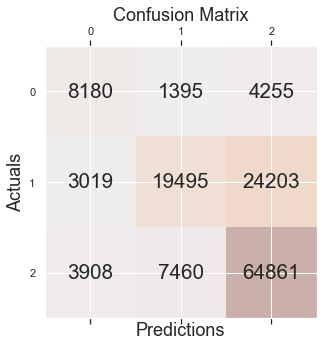

In [440]:

X = df_new[['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']]
y = df_new['Age_new']
clf = tree.DecisionTreeClassifier()
clf.fit(X,y)
y_pred = clf.predict(X)
conf_matrix = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [441]:
from sklearn.metrics import classification_report # combination of above
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.59      0.57     13830
           1       0.69      0.42      0.52     46717
           2       0.70      0.85      0.77     76229

    accuracy                           0.68    136776
   macro avg       0.64      0.62      0.62    136776
weighted avg       0.68      0.68      0.66    136776



### over_sampling

In [28]:
from imblearn.over_sampling import SMOTE

smo = SMOTE(random_state = 42)
X_smo, y_smo = smo.fit_sample(X, y)
print(Counter(y_smo))

Counter({2: 76229, 1: 76229, 0: 76229})


## 特徵重要性

In [443]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances(model, title):
    n_features = ['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.barh(np.arange(len(n_features)), importances[indices], align='center',color='salmon')
    feature_names = np.array(n_features)
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(n_features)), feature_names[indices],fontsize=14)
    plt.xlabel("Feature importance",fontsize=16)
    plt.ylabel("Feature",fontsize=16)
    plt.title(title,fontsize=22)
    plt.ylim(-1, len(n_features))
    plt.show()
    print('top 3 important features: ', np.flipud(feature_names[indices][-3:]))

Train clf.score =  0.6666375146974511
Train AC =  0.6666375146974511
Test clf.score =  0.6698587607678517
Test AC =  0.6698587607678517


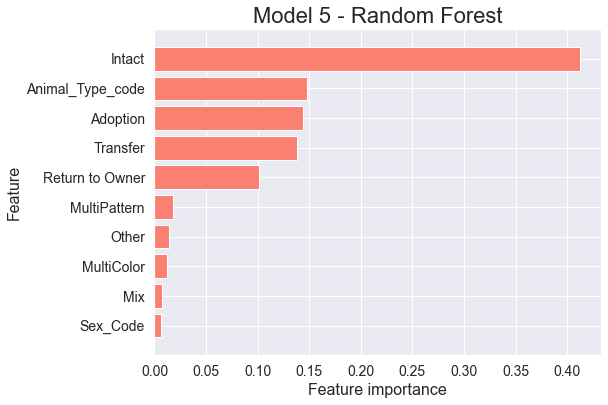

top 3 important features:  ['Intact' 'Animal_Type_code' 'Adoption']


In [444]:
from sklearn.ensemble import RandomForestClassifier
k = 10

# 將過取樣後的資料集進行訓練和測試分割
X_train_smo, X_test_smo, y_train_smo, y_test_smo = train_test_split(X_smo, y_smo, test_size=k/100, random_state=71)

# 初始化並訓練模型
model_5 = RandomForestClassifier()

model_5.fit(X_train_smo, y_train_smo)

# 在過取樣後的訓練資料上進行預測並評估結果
y_pred_smo = model_5.predict(X_train_smo)
print("Train clf.score = ", model_5.score(X_train_smo, y_train_smo))
print("Train AC = ", accuracy_score(y_pred_smo, y_train_smo))
models_train_accuracy["model_5"]=accuracy_score(y_pred_smo, y_train_smo)

y_pred_smo = model_5.predict(X_test_smo)
print("Test clf.score = ", model_5.score(X_test_smo, y_test_smo))
print("Test AC = ", accuracy_score(y_pred_smo, y_test_smo))
models_test_accuracy["model_5"]=accuracy_score(y_pred_smo, y_test_smo)

plot_feature_importances(model_5,"Model 5 - Random Forest")


### 找出最後的模型 model_6
1. 使用 smote 後的資料 X_smo, y_smo
2. 以 RandomForest 為模型，找出最佳的參數

In [272]:
from sklearn.ensemble import RandomForestClassifier

ratio = 100
ratiovalues = [i for i in range(10, ratio, 10)]
n_estimator = 250
n_estimatorvalues = [i for i in range(100, n_estimator, 50)]
depth = 10
depthvalues = [i for i in range(1, depth)]
leaf = 8
leafvalues = [i for i in range(1, leaf)]
relative_best_train_score = 0
relative_best_test_score = 0
relative_best_ratio = 0
relative_best_estimators = 0
relative_best_depth = 0
relative_best_leaf = 0

for k in ratiovalues:
    X_train, X_test, y_train, y_test = train_test_split(X_smo, y_smo, test_size=k/100, random_state=71)
    for l in n_estimatorvalues:
        for i in depthvalues:
            for j in leafvalues:
                clf = RandomForestClassifier(random_state = 71, n_estimators = l, max_depth = i, min_samples_leaf = j)
                clf.fit(X_train, y_train) #用 SMOTE 後的資料無誤 
                y_pred_train = clf.predict(X_train) #train
                train_acc = accuracy_score(y_pred_train, y_train)
                y_pred_test = clf.predict(X_test) #test
                test_acc = accuracy_score(y_pred_test, y_test)

                if ((train_acc > relative_best_train_score) and (test_acc > relative_best_test_score)):
                    relative_best_train_score = train_acc
                    relative_best_test_score = test_acc
                    relative_best_ratio = k
                    relative_best_estimators = l
                    relative_best_depth = i
                    relative_best_leaf = j

print("best ratio of testing data:", relative_best_ratio, "best no. of estimators:", relative_best_estimators, "best depth:", relative_best_depth, "best min_sample_leaf:", relative_best_leaf, \
      "\nTraining score:", relative_best_train_score, "Testing score:", relative_best_test_score)

best ratio of testing data: 10 best no. of estimators: 100 best depth: 9 best min_sample_leaf: 1 
Training score: 0.6666277973743793 Testing score: 0.669815033451397


## 儲存最好的模型 model_6
- best ratio of testing data: 10 <br>
- best no. of estimators: 100<br>
- best depth: 9 <br>
- best min_sample_leaf: 1 <br>
- Training score: 0.6666277973743793 <br>
- Testing score: 0.669815033451397

In [29]:
from sklearn.ensemble import RandomForestClassifier

k = 10

# 將過取樣後的資料集進行訓練和測試分割
X_train_smo, X_test_smo, y_train_smo, y_test_smo = train_test_split(X_smo, y_smo, test_size=k/100, random_state=71)

# 初始化並訓練模型
model_6 = RandomForestClassifier(random_state = 71, n_estimators = 100, max_depth = 9, min_samples_leaf = 1)

model_6.fit(X_train_smo, y_train_smo)

# 在過取樣後的訓練資料上進行預測並評估結果
y_pred_smo = model_6.predict(X_train_smo)
print("Train clf.score = ", model_6.score(X_train_smo, y_train_smo))
print("Train AC = ", accuracy_score(y_pred_smo, y_train_smo))
models_train_accuracy["model_6"]=accuracy_score(y_pred_smo, y_train_smo)

y_pred_smo = model_6.predict(X_test_smo)
print("Test clf.score = ", model_6.score(X_test_smo, y_test_smo))
print("Test AC = ", accuracy_score(y_pred_smo, y_test_smo))
models_test_accuracy["model_6"]=accuracy_score(y_pred_smo, y_test_smo)

plot_feature_importances(model_6,"Model 6 - Random Forest")

Train clf.score =  0.6666277973743793
Train AC =  0.6666277973743793
Test clf.score =  0.669815033451397
Test AC =  0.669815033451397


NameError: name 'plot_feature_importances' is not defined

### 最後用 K-fold 交叉驗證

In [30]:
final_model =  model_6

In [447]:
# K-fold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree

X = df_new[['Animal_Type_code','MultiColor','MultiPattern','Mix','Sex_Code','Intact','Adoption','Other','Return to Owner','Transfer']]
y = df_new['Age_new']

final_model.fit(X,y)

y_pred = final_model.predict(X)
print("clf.score = ", final_model.score(X, y))
print("AC = ", accuracy_score(y_pred, y))

fold5 = cross_val_score(final_model, X, y, cv=5)
print(fold5)

fold10 = cross_val_score(final_model, X, y, cv=10)
print(fold10)

clf.score =  0.6765368193250277
AC =  0.6765368193250277
[0.67316128 0.67592762 0.68152075 0.68144763 0.66532627]
[0.67495248 0.67173563 0.67458693 0.67721889 0.6816055  0.68131306
 0.67931564 0.6834101  0.68275207 0.64802223]


將 K-fold 結果畫圖

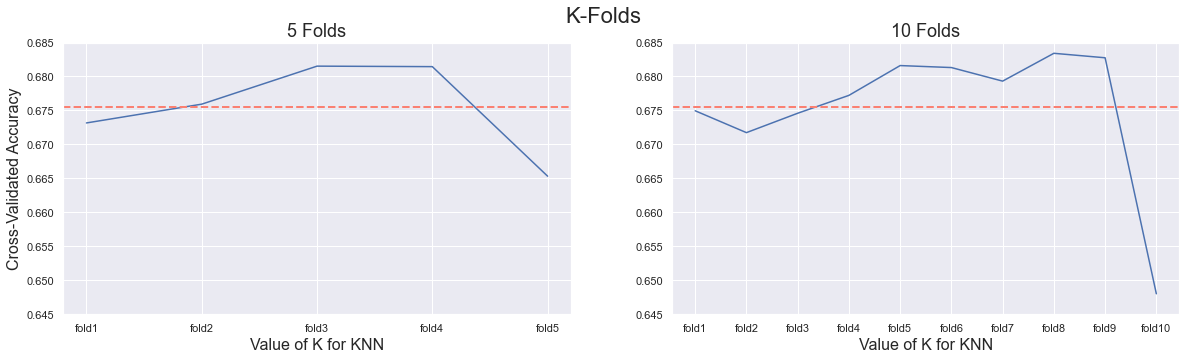

In [448]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(["fold1","fold2","fold3","fold4","fold5" ],fold5)
ax[0].set_title('5 Folds',{'fontsize': 18})
ax[0].set_xlabel('Value of K for KNN',{'fontsize': 16})
ax[0].set_ylabel('Cross-Validated Accuracy',{'fontsize': 16})
ax[0].set_ylim([0.645,0.685])

ax[1].plot(["fold1","fold2","fold3","fold4","fold5","fold6","fold7","fold8","fold9","fold10"],fold10)
ax[1].set_title('10 Folds',{'fontsize': 18})
ax[1].set_xlabel('Value of K for KNN',{'fontsize': 16})
ax[1].set_ylim([0.645,0.685])


plt.suptitle('K-Folds',fontsize = 22)

# 平均線
ax[0].axhline(np.nanmean(fold5), color='salmon', linestyle='--', linewidth=2, label='Avg')
ax[1].axhline(np.nanmean(fold10), color='salmon', linestyle='--', linewidth=2, label='Avg')
plt.show()

In [449]:
print(models_test_accuracy)
print(models_train_accuracy)

{'model_1': 0.47989472145050444, 'model_2': 0.48047960228103526, 'model_3': 0.5181313057464542, 'model_4': 0.6766340108202954, 'model_5': 0.6698587607678517, 'model_6': 0.669815033451397}
{'model_1': 0.4803652374530862, 'model_2': 0.48046272075907, 'model_3': 0.5170027132853499, 'model_4': 0.6765097727014249, 'model_5': 0.6666375146974511, 'model_6': 0.6666277973743793}


In [458]:
test_accuracy = []
train_accuracy = []

for test in models_test_accuracy:
    test_accuracy.append(test)
print(test_accuracy)

for train in models_train_accuracy:
    train_accuracy.append(train)
print(train_accuracy)

models_test_accuracy.keys()
models_test_accuracy.values()

['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']
['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']


dict_values([0.47989472145050444, 0.48047960228103526, 0.5181313057464542, 0.6766340108202954, 0.6698587607678517, 0.669815033451397])

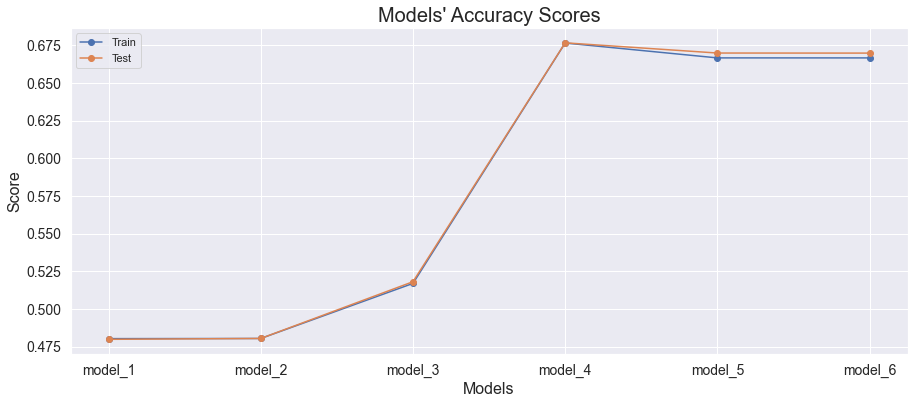

In [471]:
def plot_accuracy(title):
    plt.figure(figsize=(15,6))
    plt.plot(models_train_accuracy.keys(), models_train_accuracy.values(), '-o', label='Train')
    plt.plot(models_test_accuracy.keys(), models_test_accuracy.values(), '-o', label='Test')
    plt.title(title, fontsize=20)
    plt.xlabel("Models", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.show()

plot_accuracy('Models\' Accuracy Scores')